In [4]:
library(car) # for ANOVAs
library(pwr) # to calculate statistcal power
library(tidyverse) # for easy manipulations of dataframe and plotting with ggplot2

theme_set(theme_minimal())

In [12]:
R.Version()$version.string

[1] "R version 3.4.4 (2018-03-15)"

# Calculating statistical power

The **pwr** library provides convenient functions for the most common, simple statistical models: t-test, Chi square, Pearson correlation, one-way Aonva.

It uses the formal relationship that can be expressed for simple models between the sample size, effect size, significance level and power. It can calculate any of these 4 variables based on the others.

## Example 1 (you need always more than what you think)

How many participants do I need for a **between-group** design with **2 conditions**, with a minimum interesting **effect size** (Cohen's *d*) of **0.2**, and a **statistical power of 90%**?


In [367]:
pwr.t.test(d = 0.2, power = .9, sig.level = .05, type = "two.sample")


     Two-sample t test power calculation 

              n = 526.3332
              d = 0.2
      sig.level = 0.05
          power = 0.9
    alternative = two.sided

NOTE: n is number in *each* group


Uh... **80%**?

In [369]:
pwr.t.test(d = 0.2, power = .8, sig.level = .05, type = "two.sample")


     Two-sample t test power calculation 

              n = 393.4057
              d = 0.2
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


What if I make my design **within-subject** then?

In [368]:
pwr.t.test(d = 0.2, power = .8, sig.level = .05, type = "paired")


     Paired t test power calculation 

              n = 198.1508
              d = 0.2
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number of *pairs*


## Example 2 (keep it simple)

How many participants do I need for a **between-subject** design with **4 conditions**, with an estimated **effect size** (Cohen's *f*) of **0.25**, and a **statistical power of 80%**?


In [380]:
pwr.anova.test(k = 4, f = 0.25, power = .8, sig.level = .05)


     Balanced one-way analysis of variance power calculation 

              k = 4
              n = 44.59927
              f = 0.25
      sig.level = 0.05
          power = 0.8

NOTE: n is number in each group


In [385]:
pwr.anova.test(k = 2, f = 0.2, power = .8, sig.level = .05)
# pwr.t.test(d = 0.5, power = .8, sig.level = .05)


     Balanced one-way analysis of variance power calculation 

              k = 2
              n = 99.08032
              f = 0.2
      sig.level = 0.05
          power = 0.8

NOTE: n is number in each group



     Two-sample t test power calculation 

              n = 99.08032
              d = 0.4
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


## Example 2 (post hoc power - never do that!)

In [434]:
pwr.r.test(r = 0.48, n = 27, sig.level = .05)


     approximate correlation power calculation (arctangh transformation) 

              n = 27
              r = 0.48
      sig.level = 0.05
          power = 0.739723
    alternative = two.sided


# Consequences of low statistical power

In [298]:
### Function that simulates 2 groups of normally distributed data with a certain effect size

simulate = function(n = 20, es = 0.5, alpha = .05) {
    
    yA = rnorm(n, mean = es, sd = 1)
    yB = rnorm(n, mean = 0, sd = 1)
    
    p = t.test(yA, yB, paired = F)$p.value
    d = (mean(yA) - mean(yB)) / 1#(sqrt((sd(yA)^2+sd(yB)^2)/2))
    
    return(c(p,d))
}

## Type M and S errors at low power

In [3]:
# Theoretical power

pwr.t.test(n = 20, d = 0.1, sig.level = .05)


     Two-sample t test power calculation 

              n = 20
              d = 0.1
      sig.level = 0.05
          power = 0.06095912
    alternative = two.sided

NOTE: n is number in *each* group


In [402]:
# Power estimated from simulations

N = 10000
es = 0.1

p = vector("numeric",N)
d = vector("numeric",N)
for (k in 1:N) {
    sim = simulate(n = 20, es = es, alpha = .05)
    p[k] = sim[1]
    d[k] = sim[2]
}

sum(p < .05)/N # power estimated from simulations
mean(d) # effect size estimated from simulations 

[1] 0.0599

[1] 0.09653313

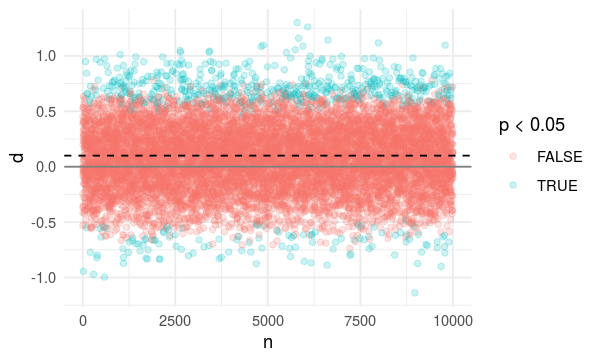

In [403]:
# Visualize simulations

ggplot(data.frame(n = seq(N), p = p, d = d),
       aes(x = n, y = d, color = p<.05)) +
geom_point(alpha = .2) +
geom_hline(yintercept = 0, color = "grey50") +
geom_hline(yintercept = es, color = "black", linetype = 2)

In [406]:
# Type M error: effect size of "successful" simulated experiments

mean(abs(d[p<.05]))/es # 1 = no magnitude amplification

[1] 7.318949

In [319]:
# Type S error: proportion of "successful" simulated experiments with the wrong sign

sum((p<.05) & (d<0))/sum(p<.05) # !!!

[1] 0.2093023

## Type M and S errors as a function of power

In [417]:
listES = seq(from = 0.1, to = 1.5, by = 0.05)

df = data.frame(es = listES, power = NA, typeM = NA, typeS = NA)

N = 1000

for (es in listES) {
    
    p = vector("numeric",N)
    d = vector("numeric",N)
    for (k in 1:N) {
        sim = simulate(n = 20, es = es, alpha = .05)
        p[k] = sim[1]
        d[k] = sim[2]
    }
    
    # True power
    df[df$es==es,"power"] = pwr.t.test(n = 20, d = es, sig.level = .05)$power
    
    # Type M error
    df[df$es==es,"typeM"] = mean(abs(d[p<.05]))/es
    
    # Type S error
    df[df$es==es,"typeS"] = sum((p<.05) & (d<0))/sum(p<.05)
 
}

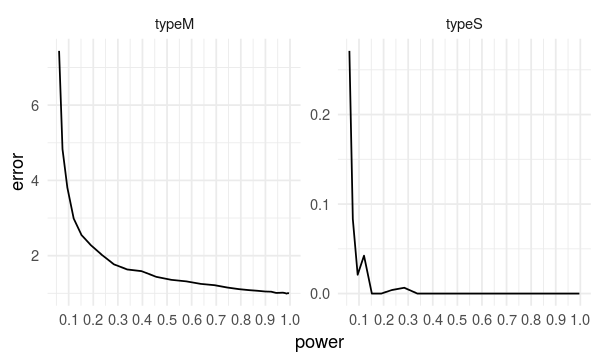

In [418]:
options(repr.plot.width=5, repr.plot.height=3)

ggplot(df %>% gather(key = type, value = error, typeM, typeS),
       aes(y = error, x = power, group = )) +
facet_wrap(. ~ type, scales = "free") +
geom_line() +
scale_x_continuous(breaks = seq(.1,1.5,.1))

## Post hoc (observed) power as a function of true power

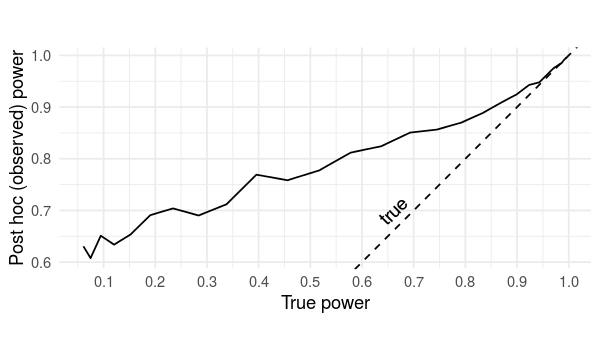

In [435]:
# Calculate
df <- df %>% mutate(power_sim2 = pwr.t.test(n = 20, d = typeM*es, sig.level = .05)$power)

# Plot
ggplot(df,
       aes(y = power_sim, x = power)) +
geom_line() +
geom_abline(slope = 1, linetype = 2) +
annotate(geom = "text", label = "true", x = .66, y = .7, angle=45) + 
scale_x_continuous(breaks = seq(.1,1.1,.1)) +
coord_fixed() +
labs(x = "True power", y = "Post hoc (observed) power")

It looks like there is a rather straightforward, close to linear relationship between *post hoc power* and *true power*, suggesting we could infer the latter from the former. However, remember that we are plotting the average over many simulations. Actually, the variability is shockingly wide as demonstrated by Daniel Lakens (https://tinyurl.com/yam9vz8y): observed power depends so much on the data that it can take pretty much any value.

# Consequences of QRPs

Code to reproduce **situation C** in Simmons, Nelson & Simonsohn 2012 (table 1):
We model with or without covariate, with or without interaction, and we choose the "most significant" one

In [8]:
### Function that does steps 1 and 2

simulate1 = function(n = 20, alpha = .05) {
    y0 = rnorm(n)
    yT = rnorm(n)
    cov = as.integer(rbernoulli(n))
    
    df = data.frame(id = seq(n), baseline = y0, treatment = yT, covariate = cov) %>%
        gather(key = condition, value = y, baseline, treatment)
    
    p = t.test(y0,yT, paired = F)$p.value
    
    p = Anova(lm(y ~ condition, df))["condition","Pr(>F)"] # equivalent to t-test
    
    # Model with covariate
    m_cov = lm(y ~ covariate + condition, df)
    p_cov = Anova(m_cov)["condition","Pr(>F)"]
    
    # Model with interaction with covariate
    m_interact = lm(y ~ condition*covariate, df)
#     print(Anova(m_interact))
    p_interact1 = Anova(m_interact)["condition","Pr(>F)"]
    p_interact2 = Anova(m_interact)["condition:covariate","Pr(>F)"]
    
#     return(m_cov)
    return(c(p,p_cov,p_interact1,p_interact2))
}


In [9]:
### Repeat steps 1 and 2 many times

N = 1000

p = vector("numeric",N)
p_qrp = vector("numeric",N)
for (k in 1:N) {
    p_sim = simulate1()
    p[k] = p_sim[1]
    p_qrp[k] = min(p_sim)
}

In [7]:
### Estimate false positive rates based on simulations

sum(p < .05)/N # we expect this one to be ~ .05
sum(p_qrp < .05)/N # we expect this one to be > .05

[1] 0.049

[1] 0.088

**Converta this notebook to R markdown**

In [12]:
library(rmarkdown)
input = "1-04.ipynb"
rmarkdown:::convert_ipynb(input, output = xfun::with_ext(input, "Rmd"))